In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy
import string
import warnings
import pickle
import os

from pgmpy.models import BayesianModel
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import HillClimbSearch,BicScore
import networkx as nx

### function - get body part location for each pair of cameras

In [4]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair

### function - align the two cameras

In [5]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [6]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [7]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint

### function - define time point of behavioral events

In [8]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint

### function - plot behavioral events

In [9]:
# from ana_functions.plot_bhv_event import plot_bhv_events
from ana_functions.plot_bhv_events_gaze_start_stop import plot_bhv_events_gaze_start_stop

### function - plot inter-pull interval

In [10]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - interval between all behavioral events

In [11]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - train the dynamic bayesian network

In [12]:
from ana_functions.train_DBN import train_DBN

### function - train the dynamic bayesian network - Alec's methods

In [13]:
# from ana_functions.train_DBN_alec import train_DBN_alec
from ana_functions.train_DBN_alec import train_DBN_gaze_start_stop

### methods used by Alec - separate into different "trials"

In [14]:
from ana_functions.train_DBN_alec import train_DBN_alec_eachtrial

## Analyze each session

In [15]:
# gaze angle threshold
# angle_thres = np.pi/36 # 5 degree
# angle_thres = np.pi/18 # 10 degree
angle_thres = np.pi/4 # 45 degree
angle_thres_name = '45'

merge_campairs = ['_average'] # "": merge the two pairs (at the level of frames); 
                              # "_pair12(23)": use camera pair 1 and 2 (2 and 3) 
                              # "_averarge": average results from pair 12 and 23 after the final analysis

# get the fps of the analyzed video
fps = 30

# re-analyze the video or not
reanalyze_video = 0

# all the videos (no misaligned ones - fixed)
# dodson scorch
if 0:
    dates_list = [
                  "20220909","20220912","20220915","20220920","20220922","20220923","20221010",
                  "20221011","20221013","20221014","20221015","20221017",
                  "20221018","20221019","20221020","20221021","20221022","20221026","20221028","20221030",
                  "20221107","20221108","20221109","20221110","20221111","20221114","20221115","20221116",

                  "20221117","20221118","20221121","20221122","20221123","20221125","20221128","20221129",              
                  "20221205","20221206","20221209","20221212","20221214","20221216","20221219","20221220","20221221",
                  "20230208","20230209","20230213","20230214","20230111","20230112","20230201",
                  "20230215"            
                 ]
# eddie sparkle
if 0:
    dates_list = [
                  "20221122","20221125","20221128","20221129","20221130","20221202","20221206",
                  "20221207","20221208","20221209","20230126","20230127","20230130","20230201","20230203-1",
                  "20230206","20230207","20230208-1","20230209","20230222","20230223-1","20230227-1",
                  "20230228-1","20230302-1","20230307-2","20230313","20230315","20230316","20230317"         
               ]
# ginger kanga
if 1:
    dates_list = [
                  "20230209","20230213","20230214","20230216","20230222","20230223","20230228","20230302",
                  "20230303","20230307","20230314","20230315","20230316","20230317"         
               ]
#    
# dates_list = ["20230209"]

ndates = np.shape(dates_list)[0]

animal1_fixedorder = 'ginger'
animal2_fixedorder = 'kanga'

animal1_filename = "Ginger"
animal2_filename = "Kanga"

# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used

#  all the videos (no misaligned ones - fixed)
# dodson scorch 
if 0:
    session_start_times = [ 
                             6.50, 18.10, 0,      33.03, 549.0, 116.80, 6.50,
                             2.80, 27.80, 272.50, 27.90, 27.00,
                            28.70, 45.30, 21.10,  27.10, 51.90,  21.00, 30.80, 17.50,                      
                            15.70,  2.65, 27.30,   0.00,  0.00,  71.80,  0.00,  0.00, 

                            75.50, 20.20,  0.00,  24.20, 36.70,  26.40, 22.50, 28.50,                       
                             0.00,  0.00, 21.70,  84.70, 17.00,  19.80, 23.50, 25.20,  0.00,
                             0.00,  0.00,   0.00,  0.00, 130.00, 14.20, 24.20, 
                            33.00
                          ] # in second
# eddie sparkle
if 0:
    session_start_times = [ 
                             8.00,38.00,1.00,3.00,5.00,9.50,1.00,
                             4.50,4.50,5.00,38.00,166.00,4.20,3.80,3.60,
                             7.50,9.00,7.50,8.50,14.50,7.80,8.00,7.50,
                             8.00,8.00,4.00,123.00,14.00,8.80 
                          ] # in second   
# ginger kanga
if 1:
    session_start_times = [ 
                             0.00,  0.00,  0.00, 48.00, 26.20, 18.00, 23.00, 28.50,
                            34.00, 25.50, 25.50, 31.50, 28.00, 30.50
                          ] # in second  
# 
# session_start_times = [0.00] # in second

session_start_frames = session_start_times * fps # fps is 30Hz


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

DAGs_all_dates = np.zeros((ndates,6,6))
DAGs_thres_dates = np.zeros((ndates,6,6))
ntempres_dates = np.zeros((ndates,1,1))
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))


try:
    # dummy
    
    # load saved data
    with open('data_saved_gaze_start_stop/DAGs_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        DAGs_all_dates = pickle.load(f)
    with open('data_saved_gaze_start_stop/DAGs_thres_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        DAGs_thres_dates = pickle.load(f)
    with open('data_saved_gaze_start_stop/ntempres_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        ntempres_dates = pickle.load(f)

    with open('data_saved_gaze_start_stop/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open('data_saved_gaze_start_stop/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open('data_saved_gaze_start_stop/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open('data_saved_gaze_start_stop/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open('data_saved_gaze_start_stop/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open('data_saved_gaze_start_stop/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)

    with open('data_saved_gaze_start_stop/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open('data_saved_gaze_start_stop/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open('data_saved_gaze_start_stop/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open('data_saved_gaze_start_stop/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open('data_saved_gaze_start_stop/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)


except:
    
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        session_start_time = session_start_times[idate]

        # folder path
        camera12_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/ysm-gpfs/pi/jadi/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"


        for imergepair in np.arange(0,np.shape(merge_campairs)[0],1):

            merge_campair = merge_campairs[imergepair]

            # load camera tracking results
            try:
                if reanalyze_video:
                    print("re-analyze the data")
                    dummy
                ## read
                with open(camera23_analyzed_path + 'body_part_locs_camera23.pkl', 'rb') as f:
                    body_part_locs_camera23 = pickle.load(f) 
                with open(camera12_analyzed_path + 'body_part_locs_camera12.pkl', 'rb') as f:
                    body_part_locs_camera12 = pickle.load(f) 
            except:
                print("did not save data - body part tracking")
                # analyze and save
                camera12_h5_file = camera12_analyzed_path +date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_weikang.h5"
                camera12_h5_data = pd.read_hdf(camera12_h5_file)
                body_part_locs_camera12 = body_part_locs_eachpair(camera12_h5_data)
                with open(camera12_analyzed_path + 'body_part_locs_camera12.pkl', 'wb') as f:
                    pickle.dump(body_part_locs_camera12, f)
                #
                camera23_h5_file = camera23_analyzed_path +date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_weikang.h5"
                camera23_h5_data = pd.read_hdf(camera23_h5_file)
                body_part_locs_camera23 = body_part_locs_eachpair(camera23_h5_data)
                with open(camera23_analyzed_path + 'body_part_locs_camera23.pkl', 'wb') as f:
                    pickle.dump(body_part_locs_camera23, f)

            # load behavioral results
            try:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_1.json"
                bhv_data_json = bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_1.json"
                session_info_json = bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_1.json"
                #
                trial_record = pd.read_json(trial_record_json)
                bhv_data = pd.read_json(bhv_data_json)
                session_info = pd.read_json(session_info_json)
            except:
                bhv_data_path = "/home/ws523/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
                trial_record_json = bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_1.json"
                bhv_data_json = bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_1.json"
                session_info_json = bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_1.json"
                #
                trial_record = pd.read_json(trial_record_json)
                bhv_data = pd.read_json(bhv_data_json)
                session_info = pd.read_json(session_info_json)

            # get animal info
            animal1 = session_info['lever1_animal'][0].lower()
            animal2 = session_info['lever2_animal'][0].lower()

            # get task type and cooperation threshold
            try:
                coop_thres = session_info["pulltime_thres"][0]
                tasktype = session_info["task_type"][0]
            except:
                coop_thres = 0
                tasktype = 1
            tasktypes_all_dates[idate] = tasktype
            coopthres_all_dates[idate] = coop_thres   

            # clean up the trial_record
            warnings.filterwarnings('ignore')
            trial_record_clean = pd.DataFrame(columns=trial_record.columns)
            for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
                # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
                trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial+1].iloc[[0]])
            trial_record_clean = trial_record_clean.reset_index(drop = True)

            # change bhv_data time to the absolute time
            time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
            for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
                ind = bhv_data["trial_number"]==itrial+1
                new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
                time_points_new["time_points_new"][ind] = new_time_itrial
            bhv_data["time_points"] = time_points_new["time_points_new"]
            bhv_data = bhv_data[bhv_data["time_points"] != 0]


            # analyze behavior results
            # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
            succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))

            trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
            #
            pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
            pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
            pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
            pulltime_diff = pulltime[1:] - pulltime[0:-1]
            interpull_intv = pulltime_diff[pullid_diff==1]
            interpull_intv = interpull_intv[interpull_intv<10]
            mean_interpull_intv = np.nanmean(interpull_intv)
            std_interpull_intv = np.nanstd(interpull_intv)
            #
            interpullintv_all_dates[idate] = mean_interpull_intv

            pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
            pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)

            # load behavioral event results
            try:
                # dummy
                if reanalyze_video:
                    print("re-analyze the data")
                    dummy
                # load data
                with open(camera23_analyzed_path + 'time_point_pull1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'rb') as f:
                    time_point_pull1 = pickle.load(f) 
                with open(camera23_analyzed_path + 'time_point_pull2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'rb') as f:
                    time_point_pull2 = pickle.load(f) 
                with open(camera23_analyzed_path + 'oneway_gaze1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'rb') as f:
                    oneway_gaze1 = pickle.load(f) 
                with open(camera23_analyzed_path + 'oneway_gaze2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'rb') as f:
                    oneway_gaze2 = pickle.load(f) 
                with open(camera23_analyzed_path + 'mutual_gaze1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'rb') as f:
                    mutual_gaze1 = pickle.load(f) 
                with open(camera23_analyzed_path + 'mutual_gaze2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'rb') as f:
                    mutual_gaze2 = pickle.load(f) 
            except:
                if merge_campair != '_average':
                    if merge_campair == '':
                        print("did not save data - align two pairs and get social gazes")
                        # Align the two pairs of camera
                        RR_sum, tt_sum, err_sum = camera_align(body_part_locs_camera23, body_part_locs_camera12)
                        # Merge two pairs of camera
                        body_part_locs_merge = camera_merge(body_part_locs_camera23, body_part_locs_camera12, RR_sum, tt_sum, err_sum)
                    elif merge_campair == '_pair12':
                        print("did not save data - only use camera pair 1 and 2")
                        body_part_locs_merge = body_part_locs_camera12
                    elif merge_campair == '_pair23':
                        print("did not save data - only use camera pair 2 and 3")
                        body_part_locs_merge = body_part_locs_camera23            

                    # get social gaze information 
                    eye_direction_merge, eye_contact_or_not_merge, look_at_face_or_not_merge = find_socialgaze_timepoint(body_part_locs_camera23, body_part_locs_camera12, body_part_locs_merge, angle_thres)
                    # change the unit to second
                    session_start_time = session_start_times[idate]
                    eye_direction_merge['time_in_second'] = np.arange(0,np.shape(eye_direction_merge['dodson'])[0],1)/fps - session_start_time
                    eye_contact_or_not_merge['time_in_second'] = np.arange(0,np.shape(eye_contact_or_not_merge['dodson'])[0],1)/fps - session_start_time
                    look_at_face_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_merge['dodson'])[0],1)/fps - session_start_time 

                    # find time point of behavioral events
                    time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2 = bhv_events_timepoint(bhv_data,animal1,animal2, eye_direction_merge, eye_contact_or_not_merge, look_at_face_or_not_merge)
                    # save data
                    with open(camera23_analyzed_path + 'time_point_pull1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
                        pickle.dump(time_point_pull1, f)
                    with open(camera23_analyzed_path + 'time_point_pull2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
                        pickle.dump(time_point_pull2, f)
                    with open(camera23_analyzed_path + 'oneway_gaze1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
                        pickle.dump(oneway_gaze1, f)
                    with open(camera23_analyzed_path + 'oneway_gaze2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
                        pickle.dump(oneway_gaze2, f)
                    with open(camera23_analyzed_path + 'mutual_gaze1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
                        pickle.dump(mutual_gaze1, f)
                    with open(camera23_analyzed_path + 'mutual_gaze2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
                        pickle.dump(mutual_gaze2, f)           

                elif merge_campair == '_average':
                    # calculate camera 12 first
                    #
                    body_part_locs_merge = body_part_locs_camera12           
                    # get social gaze information 
                    eye_direction_merge, eye_contact_or_not_merge, look_at_face_or_not_merge = find_socialgaze_timepoint(body_part_locs_camera23, body_part_locs_camera12, body_part_locs_merge, angle_thres)
                    # change the unit to second
                    session_start_time = session_start_times[idate]
                    eye_direction_merge['time_in_second'] = np.arange(0,np.shape(eye_direction_merge['dodson'])[0],1)/fps - session_start_time
                    eye_contact_or_not_merge['time_in_second'] = np.arange(0,np.shape(eye_contact_or_not_merge['dodson'])[0],1)/fps - session_start_time
                    look_at_face_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_merge['dodson'])[0],1)/fps - session_start_time 
                    # find time point of behavioral events
                    time_point_pull1_12, time_point_pull2_12, oneway_gaze1_12, oneway_gaze2_12, mutual_gaze1_12, mutual_gaze2_12 = bhv_events_timepoint(bhv_data, animal1, animal2, eye_direction_merge, eye_contact_or_not_merge, look_at_face_or_not_merge)
                    #

                    # calculate camera 23 second
                    #
                    body_part_locs_merge = body_part_locs_camera23           
                    # get social gaze information 
                    eye_direction_merge, eye_contact_or_not_merge, look_at_face_or_not_merge = find_socialgaze_timepoint(body_part_locs_camera23, body_part_locs_camera12, body_part_locs_merge, angle_thres)
                    # change the unit to second
                    session_start_time = session_start_times[idate]
                    eye_direction_merge['time_in_second'] = np.arange(0,np.shape(eye_direction_merge['dodson'])[0],1)/fps - session_start_time
                    eye_contact_or_not_merge['time_in_second'] = np.arange(0,np.shape(eye_contact_or_not_merge['dodson'])[0],1)/fps - session_start_time
                    look_at_face_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_face_or_not_merge['dodson'])[0],1)/fps - session_start_time 
                    # find time point of behavioral events
                    time_point_pull1_23, time_point_pull2_23, oneway_gaze1_23, oneway_gaze2_23, mutual_gaze1_23, mutual_gaze2_23 = bhv_events_timepoint(bhv_data, animal1, animal2, eye_direction_merge, eye_contact_or_not_merge, look_at_face_or_not_merge)
                    #

                    # put 12 and 23 data together
                    time_point_pull1 = np.concatenate([time_point_pull1_12,time_point_pull1_23])
                    time_point_pull1 = np.sort(np.unique(time_point_pull1))
                    time_point_pull1 = pd.Series(time_point_pull1)
                    #
                    time_point_pull2 = np.concatenate([time_point_pull2_12,time_point_pull2_23])
                    time_point_pull2 = np.sort(np.unique(time_point_pull2))
                    time_point_pull2 = pd.Series(time_point_pull2)          
                    #
                    animal1_gaze = np.concatenate([oneway_gaze1_12,oneway_gaze1_23,mutual_gaze1_12,mutual_gaze1_23])
                    animal1_gaze = np.sort(np.unique(animal1_gaze))
                    #
                    animal2_gaze = np.concatenate([oneway_gaze2_12,oneway_gaze2_23,mutual_gaze2_12,mutual_gaze2_23])
                    animal2_gaze = np.sort(np.unique(animal2_gaze))
                    #
                    ngaze1 = len(animal1_gaze)
                    ngaze2 = len(animal2_gaze)
                    oneway_gaze1 = []
                    oneway_gaze2 = []
                    mutual_gaze1 = []
                    mutual_gaze2 = []
                    # 
                    for igaze1 in np.arange(0, ngaze1, 1):
                        for igaze2 in np.arange(0,ngaze2,1):
                            if abs(animal1_gaze[igaze1]-animal2_gaze[igaze2])<1:
                                mutual_gaze1.append(animal1_gaze[igaze1])
                                mutual_gaze2.append(animal2_gaze[igaze2])
                    mutual_gaze1 = np.unique(mutual_gaze1)   
                    mutual_gaze2 = np.unique(mutual_gaze2)
                    oneway_gaze1 = animal1_gaze[~np.isin(animal1_gaze,mutual_gaze1)]
                    oneway_gaze2 = animal2_gaze[~np.isin(animal2_gaze,mutual_gaze2)]
                    #

                    # save data
                    with open(camera23_analyzed_path + 'time_point_pull1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
                        pickle.dump(time_point_pull1, f)
                    with open(camera23_analyzed_path + 'time_point_pull2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
                        pickle.dump(time_point_pull2, f)
                    with open(camera23_analyzed_path + 'oneway_gaze1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
                        pickle.dump(oneway_gaze1, f)
                    with open(camera23_analyzed_path + 'oneway_gaze2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
                        pickle.dump(oneway_gaze2, f)
                    with open(camera23_analyzed_path + 'mutual_gaze1'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
                        pickle.dump(mutual_gaze1, f)
                    with open(camera23_analyzed_path + 'mutual_gaze2'+merge_campair+'_gazeAngle'+angle_thres_name+'.pkl', 'wb') as f:
                        pickle.dump(mutual_gaze2, f)

            # # plot behavioral events
            gaze_thresold = 1.05 # time window threshold to define gaze event belongs to the same social gaze
            if np.isin(animal1,animal1_fixedorder):
                if merge_campair == '':
                    plot_bhv_events_gaze_start_stop(gaze_thresold,date_tgt+'_merged',animal1, animal2, session_start_time, 600, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                else:
                    plot_bhv_events_gaze_start_stop(gaze_thresold,date_tgt+merge_campair,animal1, animal2, session_start_time, 600, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
            else:
                if merge_campair == '':
                    plot_bhv_events_gaze_start_stop(gaze_thresold,date_tgt+'_merged',animal2, animal1, session_start_time, 600, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
                else:
                    plot_bhv_events_gaze_start_stop(gaze_thresold,date_tgt+merge_campair,animal2, animal1, session_start_time, 600, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)
            #
            # save behavioral events plot
            if 1:
                current_dir = os.getcwd()+'/bhv_events_comparison'
                add_date_dir = os.path.join(current_dir,date_tgt)
                if not os.path.exists(add_date_dir):
                    os.makedirs(add_date_dir)
                if merge_campair == '':
                    plt.savefig("bhv_events_comparison/"+date_tgt+'/'+date_tgt+"_merged_gaze_start_stop.pdf")
                else:
                    plt.savefig("bhv_events_comparison/"+date_tgt+'/'+date_tgt+merge_campair+"_gaze_start_stop.pdf")

            #
            owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
            owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
            mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
            mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]



            # # train the dynamic bayesian network - Alec's model, try different time step
            if 1:
                # temp_resolus = [0.5,1,1.5,2,2.5,3,3.5,4,4.5,5,5.5,6,6.5,7,7.5,8,8.5] # temporal resolution in the DBN model, eg: 0.5 means 500ms
                # use bhv event to decide temporal resolution     
                totalsess_time = 600 # total session time in s
                low_lim,up_lim,_ = bhv_events_interval(totalsess_time, session_start_time, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                temp_resolus = temp_resolus = np.arange(low_lim,up_lim,0.1)

                ntemp_reses = np.shape(temp_resolus)[0]

                gaze_thresold = 1.05

                DAGs_all_tempres = np.zeros([6,6])
                for temp_resolu in temp_resolus:
                    if np.isin(animal1,animal1_fixedorder):
                        best_model,edges,DAGs,eventnames,from_pops,to_pops,whitelist = train_DBN_gaze_start_stop(gaze_thresold, totalsess_time, session_start_time, temp_resolu, time_point_pull1, time_point_pull2, oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2)
                    else:
                        best_model,edges,DAGs,eventnames,from_pops,to_pops,whitelist = train_DBN_gaze_start_stop(gaze_thresold, totalsess_time, session_start_time, temp_resolu, time_point_pull2, time_point_pull1, oneway_gaze2, oneway_gaze1, mutual_gaze2, mutual_gaze1)     
                    print(edges)
                    DAGs[0][np.isnan(DAGs[0])]=0
                    DAGs_all_tempres = DAGs_all_tempres + DAGs[0]

                DAGs_all_tempres = DAGs_all_tempres/ntemp_reses
                DAGs_thres_tempres = np.zeros([6,6])
                DAGs_thres_tempres[DAGs_all_tempres>0.25]=1
                #
                DAGs_all_dates[idate,:,:]= DAGs_all_tempres
                DAGs_thres_dates[idate,:,:] = DAGs_thres_tempres
                ntempres_dates[idate,:,:] = ntemp_reses
                #
                # edge_list = [(from_pop,to_pop) for from_pop in from_pops for to_pop in to_pops]
                # ind_edges = np.reshape(np.transpose(np.mean(DAGs_thres_dates,axis=0)>0.15),(16,1))
                # edges_good = [edge_list[i] for i in np.where(ind_edges)[0]]

                
    # save data
    if 1:
        with open('data_saved_gaze_start_stop/DAGs_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGs_all_dates, f)
        with open('data_saved_gaze_start_stop/DAGs_thres_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(DAGs_thres_dates, f)
        with open('data_saved_gaze_start_stop/ntempres_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(ntempres_dates, f)

        with open('data_saved_gaze_start_stop/owgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open('data_saved_gaze_start_stop/owgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open('data_saved_gaze_start_stop/mtgaze1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open('data_saved_gaze_start_stop/mtgaze2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open('data_saved_gaze_start_stop/pull1_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open('data_saved_gaze_start_stop/pull2_num_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)

        with open('data_saved_gaze_start_stop/tasktypes_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open('data_saved_gaze_start_stop/coopthres_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open('data_saved_gaze_start_stop/succ_rate_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open('data_saved_gaze_start_stop/interpullintv_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open('data_saved_gaze_start_stop/trialnum_all_dates_'+animal1_fixedorder[0]+animal2_fixedorder[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)

                 
    

### plot the transition probability from social gaze to pull

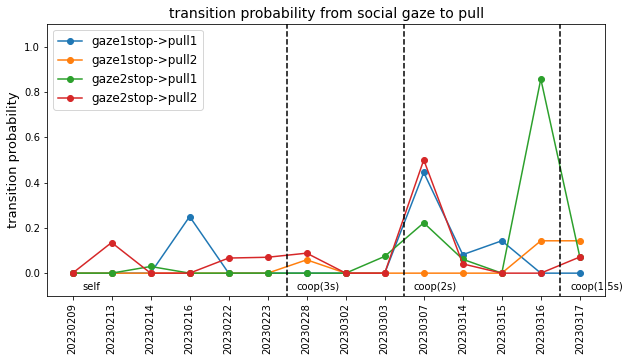

In [16]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
#
ax1.plot(DAGs_all_dates[sorting_df.index,4,0],'o-',label = "gaze1stop->pull1")
ax1.plot(DAGs_all_dates[sorting_df.index,4,1],'o-',label = "gaze1stop->pull2")
ax1.plot(DAGs_all_dates[sorting_df.index,5,0],'o-',label = "gaze2stop->pull1")
ax1.plot(DAGs_all_dates[sorting_df.index,5,1],'o-',label = "gaze2stop->pull2")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from social gaze to pull", fontsize = 14)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.15,1.15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.075,tasktypes[itaskswitch],fontsize=10)
#
plt.show()

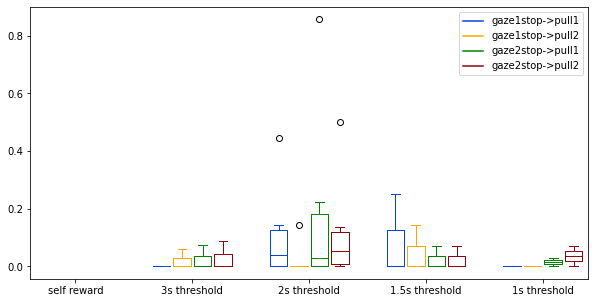

In [17]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

gaze1_pull1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],4,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],4,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],4,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],4,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],4,0]]
gaze1_pull2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],4,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],4,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],4,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],4,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],4,1]]
gaze2_pull1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],5,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],5,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],5,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],5,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],5,0]]
gaze2_pull2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],5,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],5,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],5,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],5,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],5,1]]
gaze1_pull1_plot = plt.boxplot(gaze1_pull1,positions=np.array(np.arange(len(gaze1_pull1)))*4.0-1.05,widths=0.6)
gaze1_pull2_plot = plt.boxplot(gaze1_pull2,positions=np.array(np.arange(len(gaze1_pull2)))*4.0-0.35,widths=0.6)
gaze2_pull1_plot = plt.boxplot(gaze2_pull1,positions=np.array(np.arange(len(gaze2_pull1)))*4.0+0.35,widths=0.6)
gaze2_pull2_plot = plt.boxplot(gaze2_pull2,positions=np.array(np.arange(len(gaze2_pull2)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(gaze1_pull1_plot, '#0343DF', 'gaze1stop->pull1')
define_box_properties(gaze1_pull2_plot, '#FFA500', 'gaze1stop->pull2')
define_box_properties(gaze2_pull1_plot, '#008000', 'gaze2stop->pull1')
define_box_properties(gaze2_pull2_plot, '#8C000F', 'gaze2stop->pull2')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot the transition probability from pull to social gaze

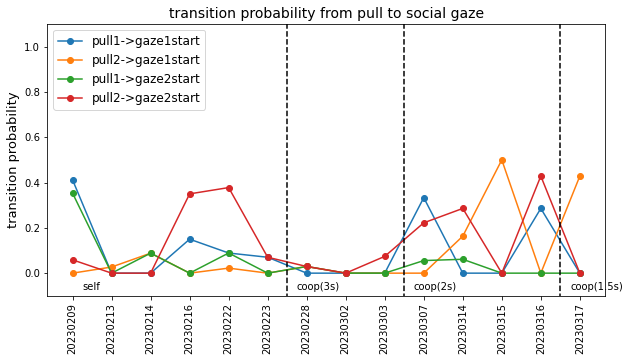

In [18]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
#
ax1.plot(DAGs_all_dates[sorting_df.index,0,2],'o-',label = "pull1->gaze1start")
ax1.plot(DAGs_all_dates[sorting_df.index,1,2],'o-',label = "pull2->gaze1start")
ax1.plot(DAGs_all_dates[sorting_df.index,0,3],'o-',label = "pull1->gaze2start")
ax1.plot(DAGs_all_dates[sorting_df.index,1,3],'o-',label = "pull2->gaze2start")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from pull to social gaze", fontsize = 14)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.15,1.15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.075,tasktypes[itaskswitch],fontsize=10)
#
plt.show()

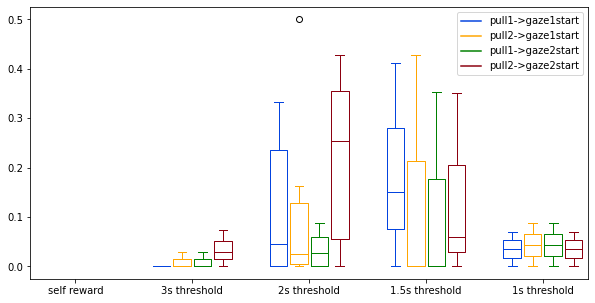

In [19]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

pull1_gaze1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],0,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],0,2]]
pull2_gaze1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],1,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],1,2]]
pull1_gaze2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],0,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],0,3]]
pull2_gaze2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],1,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],1,3]]
pull1_gaze1_plot = plt.boxplot(pull1_gaze1,positions=np.array(np.arange(len(pull1_gaze1)))*4.0-1.05,widths=0.6)
pull2_gaze1_plot = plt.boxplot(pull2_gaze1,positions=np.array(np.arange(len(pull2_gaze1)))*4.0-0.35,widths=0.6)
pull1_gaze2_plot = plt.boxplot(pull1_gaze2,positions=np.array(np.arange(len(pull1_gaze2)))*4.0+0.35,widths=0.6)
pull2_gaze2_plot = plt.boxplot(pull2_gaze2,positions=np.array(np.arange(len(pull2_gaze2)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(pull1_gaze1_plot, '#0343DF', 'pull1->gaze1start')
define_box_properties(pull2_gaze1_plot, '#FFA500', 'pull2->gaze1start')
define_box_properties(pull1_gaze2_plot, '#008000', 'pull1->gaze2start')
define_box_properties(pull2_gaze2_plot, '#8C000F', 'pull2->gaze2start')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot the transition probability from pull to pull

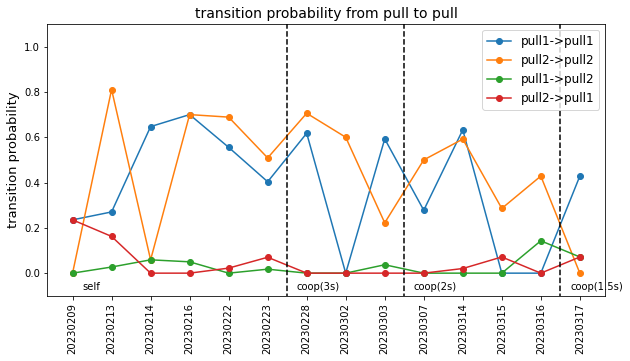

In [20]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
#
ax1.plot(DAGs_all_dates[sorting_df.index,0,0],'o-',label = "pull1->pull1")
ax1.plot(DAGs_all_dates[sorting_df.index,1,1],'o-',label = "pull2->pull2")
ax1.plot(DAGs_all_dates[sorting_df.index,0,1],'o-',label = "pull1->pull2")
ax1.plot(DAGs_all_dates[sorting_df.index,1,0],'o-',label = "pull2->pull1")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from pull to pull", fontsize = 14)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.15,1.15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.075,tasktypes[itaskswitch],fontsize=10)
#
plt.show()

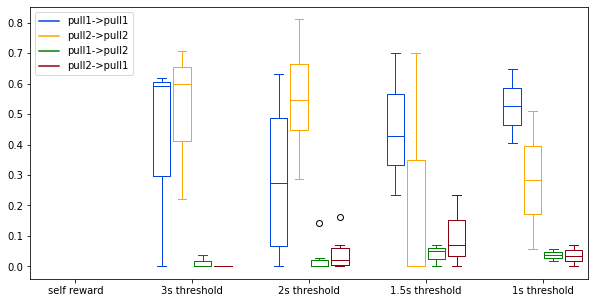

In [21]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

pull1_pull1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],0,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],0,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],0,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],0,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],0,0]]
pull2_pull2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],1,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],1,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],1,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],1,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],1,1]]
pull1_pull2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],0,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],0,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],0,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],0,1],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],0,1]]
pull2_pull1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],1,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],1,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],1,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],1,0],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],1,0]]
pull1_pull1_plot = plt.boxplot(pull1_pull1,positions=np.array(np.arange(len(gaze1_pull1)))*4.0-1.05,widths=0.6)
pull2_pull2_plot = plt.boxplot(pull2_pull2,positions=np.array(np.arange(len(gaze1_pull2)))*4.0-0.35,widths=0.6)
pull1_pull2_plot = plt.boxplot(pull1_pull2,positions=np.array(np.arange(len(gaze2_pull1)))*4.0+0.35,widths=0.6)
pull2_pull1_plot = plt.boxplot(pull2_pull1,positions=np.array(np.arange(len(gaze2_pull2)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(pull1_pull1_plot, '#0343DF', 'pull1->pull1')
define_box_properties(pull2_pull2_plot, '#FFA500', 'pull2->pull2')
define_box_properties(pull1_pull2_plot, '#008000', 'pull1->pull2')
define_box_properties(pull2_pull1_plot, '#8C000F', 'pull2->pull1')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot the transition probability from social gaze to social gaze

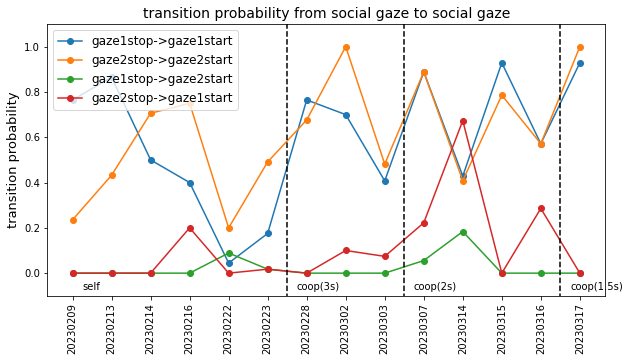

In [22]:
fig, ax1 = plt.subplots(figsize=(10, 5))
#
# sort the data based on task type and dates
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
#
ax1.plot(DAGs_all_dates[sorting_df.index,4,2],'o-',label = "gaze1stop->gaze1start")
ax1.plot(DAGs_all_dates[sorting_df.index,5,3],'o-',label = "gaze2stop->gaze2start")
ax1.plot(DAGs_all_dates[sorting_df.index,4,3],'o-',label = "gaze1stop->gaze2start")
ax1.plot(DAGs_all_dates[sorting_df.index,5,2],'o-',label = "gaze2stop->gaze1start")
ax1.legend(fontsize=12)
ax1.set_ylim(-0.1,1.1)
ax1.set_ylabel("transition probability",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
plt.title("transition probability from social gaze to social gaze", fontsize = 14)
#
tasktypes = ['self','coop(3s)','coop(2s)','coop(1.5s)','coop(1s)']
taskswitches = np.where(np.array(sorting_df['coopthres'])[1:]-np.array(sorting_df['coopthres'])[:-1]!=0)[0]+0.5
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.plot([taskswitch,taskswitch],[-0.15,1.15],'k--')
taskswitches = np.concatenate(([0],taskswitches))
for itaskswitch in np.arange(0,np.shape(taskswitches)[0],1):
    taskswitch = taskswitches[itaskswitch]
    ax1.text(taskswitch+0.25,-0.075,tasktypes[itaskswitch],fontsize=10)
#
plt.show()

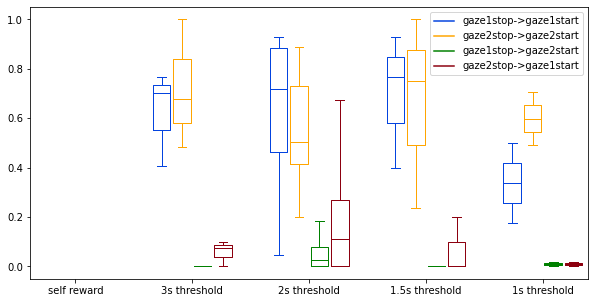

In [23]:
fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

gaze1_gaze1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],4,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],4,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],4,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],4,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],4,2]]
gaze2_gaze2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],5,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],5,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],5,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],5,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],5,3]]
gaze1_gaze2 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],4,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],4,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],4,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],4,3],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],4,3]]
gaze2_gaze1 = [DAGs_all_dates[np.transpose(coopthres_all_dates==0)[0],5,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==3)[0],5,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==2)[0],5,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1.5)[0],5,2],
               DAGs_all_dates[np.transpose(coopthres_all_dates==1)[0],5,2]]
gaze1_gaze1_plot = plt.boxplot(gaze1_gaze1,positions=np.array(np.arange(len(gaze1_gaze1)))*4.0-1.05,widths=0.6)
gaze2_gaze2_plot = plt.boxplot(gaze2_gaze2,positions=np.array(np.arange(len(gaze2_gaze2)))*4.0-0.35,widths=0.6)
gaze1_gaze2_plot = plt.boxplot(gaze1_gaze2,positions=np.array(np.arange(len(gaze1_gaze2)))*4.0+0.35,widths=0.6)
gaze2_gaze1_plot = plt.boxplot(gaze2_gaze1,positions=np.array(np.arange(len(gaze2_gaze1)))*4.0+1.05,widths=0.6)
#
def define_box_properties(plot_name, color_code, label):
    for k, v in plot_name.items():
        plt.setp(plot_name.get(k), color=color_code)
    plt.plot([], c=color_code, label=label)
    plt.legend()
#
define_box_properties(gaze1_gaze1_plot, '#0343DF', 'gaze1stop->gaze1start')
define_box_properties(gaze2_gaze2_plot, '#FFA500', 'gaze2stop->gaze2start')
define_box_properties(gaze1_gaze2_plot, '#008000', 'gaze1stop->gaze2start')
define_box_properties(gaze2_gaze1_plot, '#8C000F', 'gaze2stop->gaze1start')
#
# set the x label values
plt.xticks(np.arange(0, len(grouptypes)*4, 4), grouptypes);

### plot between behavioral measures - successful rate vs interpull interval

Text(0, 1, 'corr r = -0.08; corr p = 0.84')

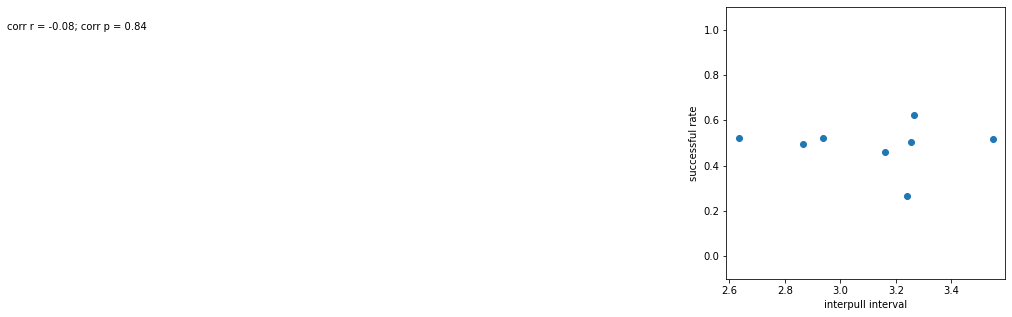

In [24]:
fig, axs = plt.subplots(1,1,figsize=(5, 5))

# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1) 
#
xxx = interpullintv_all_dates[ind]
yyy = succ_rate_all_dates[ind]
axs.plot(xxx,yyy,'o')
axs.set_xlabel('interpull interval')
axs.set_ylabel('successful rate')
# axs.set_xlim([-0.1,1.1])
axs.set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy)
axs.text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### sanity check: plot the pull transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = 0.39; corr p = 0.14')

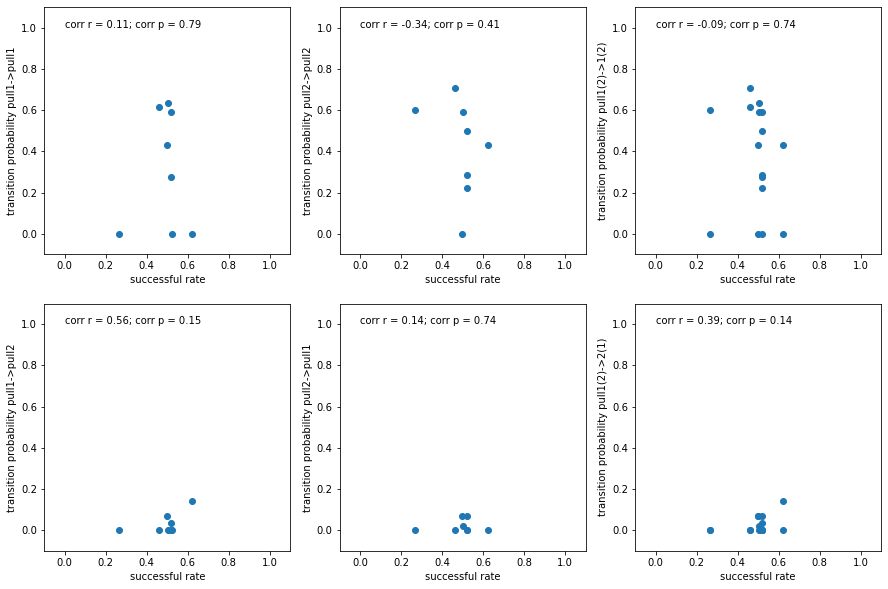

In [25]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)
#
xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],0,0]
y1label = "pull1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],1,1]
y2label = "pull2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],0,1]
y3label = "pull1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],1,0]
y4label = "pull2->pull1"
#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability pull1(2)->1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability pull1(2)->2(1)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### sanity check: plot the pull transition probability vs behavioral measures - interpull interval

Text(0, 1, 'corr r = -0.04; corr p = 0.88')

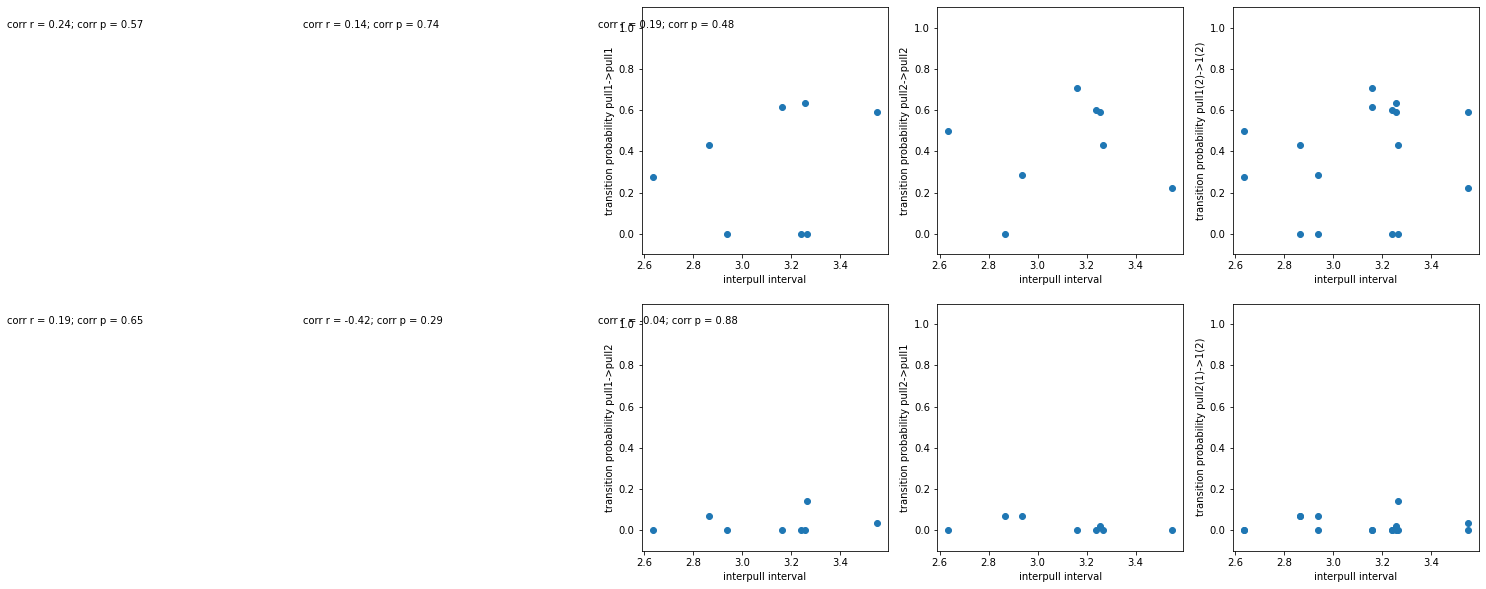

In [26]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1) 
#
xxx  = interpullintv_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],0,0]
y1label = "pull1->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],1,1]
y2label = "pull2->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],0,1]
y3label = "pull1->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],1,0]
y4label = "pull2->pull1"
#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('interpull interval')
axs[0,0].set_ylabel('transition probability '+y1label)
#axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('interpull interval')
axs[0,1].set_ylabel('transition probability '+y2label)
#axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('interpull interval')
axs[1,0].set_ylabel('transition probability '+y3label)
#axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('interpull interval')
axs[1,1].set_ylabel('transition probability '+y4label)
#axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('interpull interval')
axs[0,2].set_ylabel('transition probability pull1(2)->1(2)')
#axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('interpull interval')
axs[1,2].set_ylabel('transition probability pull2(1)->1(2)')
#axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the gaze->pull transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = 0.46; corr p = 0.07')

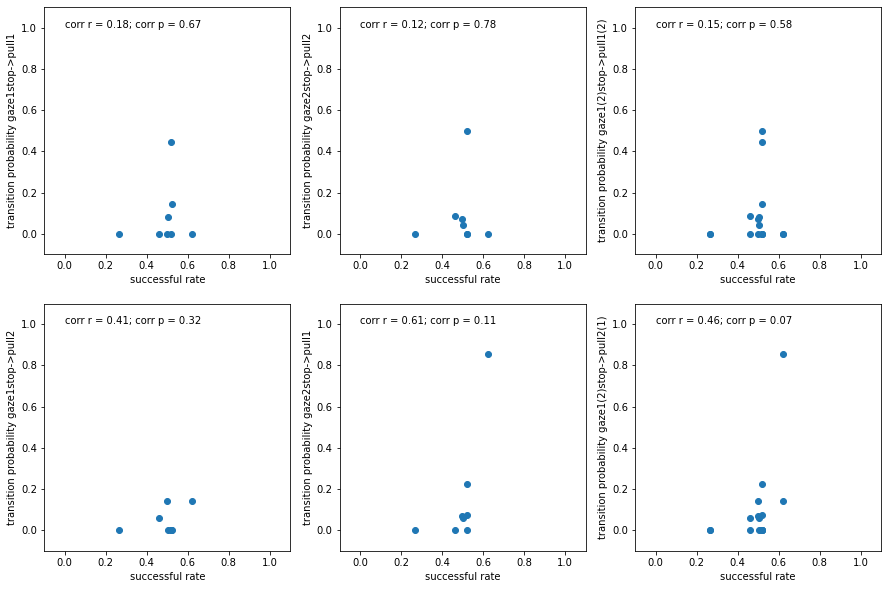

In [27]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],4,0]
y1label = "gaze1stop->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],5,1]
y2label = "gaze2stop->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],4,1]
y3label = "gaze1stop->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],5,0]
y4label = "gaze2stop->pull1"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability gaze1(2)stop->pull1(2)')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability gaze1(2)stop->pull2(1)')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the pull -> gaze transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = 0.1; corr p = 0.71')

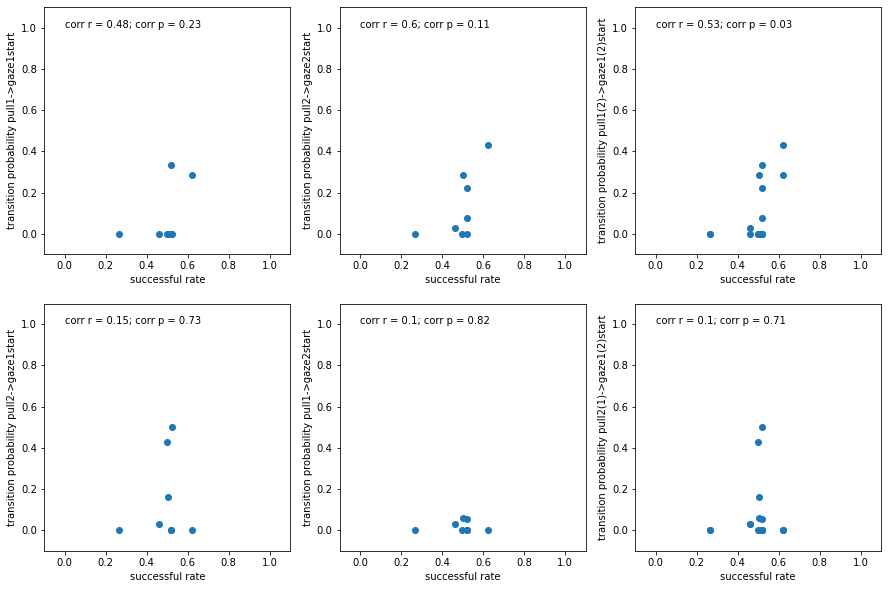

In [28]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],0,2]
y1label = "pull1->gaze1start"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],1,3]
y2label = "pull2->gaze2start"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],1,2]
y3label = "pull2->gaze1start"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],0,3]
y4label = "pull1->gaze2start"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability pull1(2)->gaze1(2)start')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability pull2(1)->gaze1(2)start')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the gaze -> gaze transition probability vs behavioral measures - successful rate

Text(0, 1, 'corr r = 0.15; corr p = 0.58')

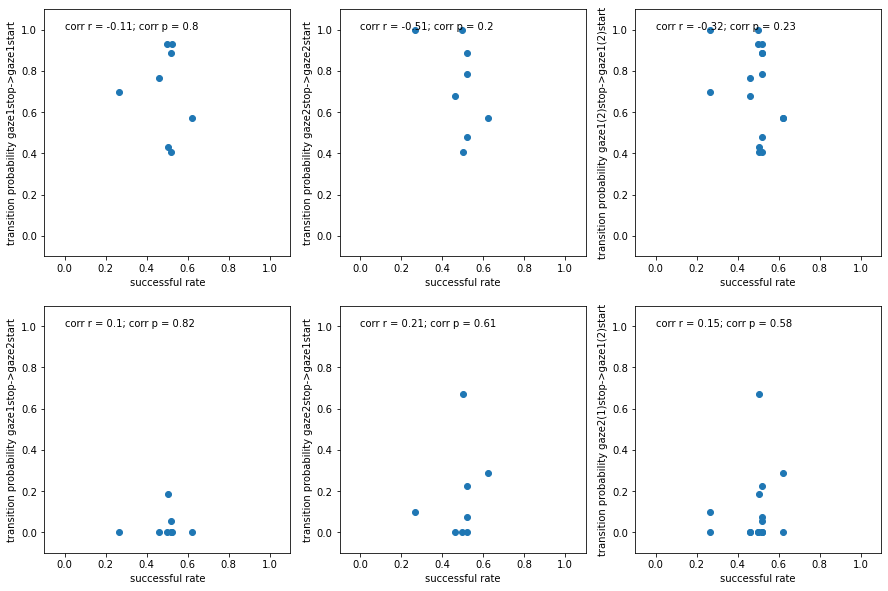

In [29]:
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = succ_rate_all_dates[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],4,2]
y1label = "gaze1stop->gaze1start"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],5,3]
y2label = "gaze2stop->gaze2start"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],4,3]
y3label = "gaze1stop->gaze2start"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],5,2]
y4label = "gaze2stop->gaze1start"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('successful rate')
axs[0,0].set_ylabel('transition probability '+y1label)
axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('successful rate')
axs[0,1].set_ylabel('transition probability '+y2label)
axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('successful rate')
axs[1,0].set_ylabel('transition probability '+y3label)
axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('successful rate')
axs[1,1].set_ylabel('transition probability '+y4label)
axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('successful rate')
axs[0,2].set_ylabel('transition probability gaze1(2)stop->gaze1(2)start')
axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('successful rate')
axs[1,2].set_ylabel('transition probability gaze2(1)stop->gaze1(2)start')
axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))

### plot the gaze->pull transition probability vs gaze/pull ratio

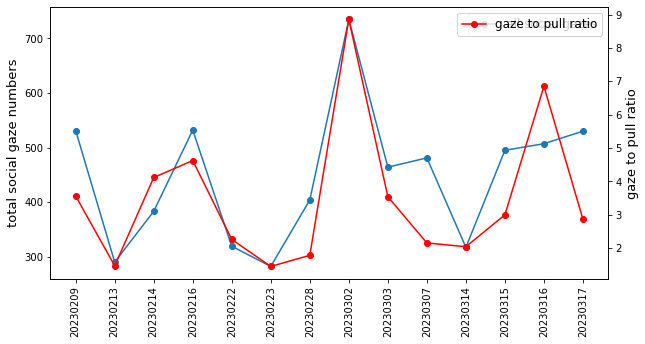

In [30]:
#
# sort the data based on task type and dates
coopthres_forsort = (tasktypes_all_dates-1)*coopthres_all_dates/2
coopthres_forsort[coopthres_forsort==0] = 100 # get the cooperation threshold for sorting
sorting_df = pd.DataFrame({'dates': dates_list, 'coopthres': coopthres_forsort.ravel()}, columns=['dates', 'coopthres'])
sorting_df = sorting_df.sort_values(by=['coopthres','dates'], ascending = [False, True])
#

gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)

fig, ax1 = plt.subplots(figsize=(10, 5))
#
ax1.plot(gaze_numbers[sorting_df.index],'o-',label = "all social gazes")

ax1.legend(fontsize=12)
ax1.set_ylabel("total social gaze numbers",fontsize=13)
#
plt.xticks(np.arange(0,ndates,1),np.array(dates_list)[sorting_df.index], rotation=90,fontsize=10)
plt.yticks(fontsize=10)
#
ax2 = ax1.twinx()
ax2.plot(gaze_pull_ratios[sorting_df.index],'ro-',label = "gaze to pull ratio")
ax2.legend(fontsize=12)
ax2.set_ylabel("gaze to pull ratio",fontsize=13)
#
plt.show()


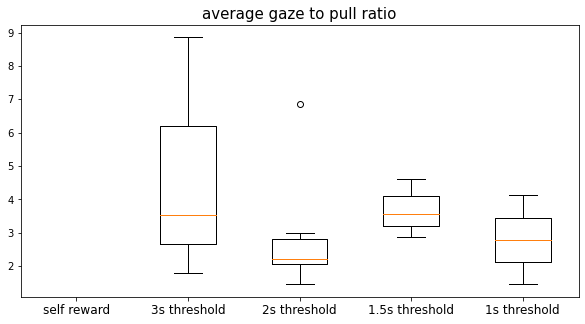

In [31]:
gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)

fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

gaze_numbers_groups = [np.transpose(gaze_pull_ratios[np.transpose(coopthres_all_dates==0)[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose(coopthres_all_dates==3)[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose(coopthres_all_dates==2)[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose(coopthres_all_dates==1.5)[0]])[0],
                       np.transpose(gaze_pull_ratios[np.transpose(coopthres_all_dates==1)[0]])[0]]

gaze_numbers_plot = plt.boxplot(gaze_numbers_groups)

plt.xticks(np.arange(1, len(grouptypes)+1, 1), grouptypes, fontsize = 12);
plt.title('average gaze to pull ratio',fontsize = 15);

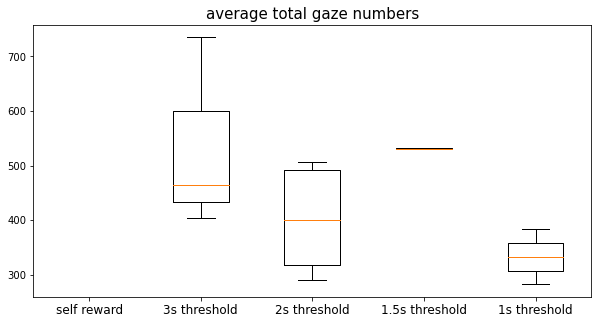

In [32]:
gaze_numbers = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)

fig, ax1 = plt.subplots(figsize=(10, 5))

grouptypes = ['self reward','3s threshold','2s threshold','1.5s threshold','1s threshold']

gaze_numbers_groups = [np.transpose(gaze_numbers[np.transpose(coopthres_all_dates==0)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_all_dates==3)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_all_dates==2)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_all_dates==1.5)[0]])[0],
                       np.transpose(gaze_numbers[np.transpose(coopthres_all_dates==1)[0]])[0]]

gaze_numbers_plot = plt.boxplot(gaze_numbers_groups)

plt.xticks(np.arange(1, len(grouptypes)+1, 1), grouptypes, fontsize = 12);
plt.title('average total gaze numbers',fontsize = 15);

Text(0, 1, 'corr r = -0.05; corr p = 0.72')

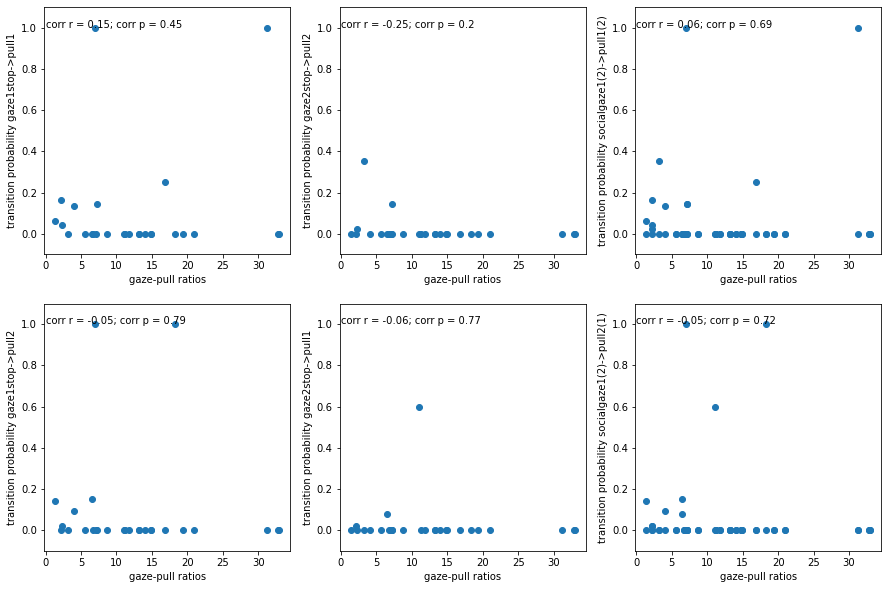

In [31]:
gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)/(pull1_num_all_dates+pull2_num_all_dates)
# gaze_pull_ratios = (owgaze1_num_all_dates+owgaze2_num_all_dates+mtgaze1_num_all_dates+mtgaze2_num_all_dates)
fig, axs = plt.subplots(2,3,figsize=(15, 10))

# ind = (tasktypes_all_dates != 1) & (succ_rate_all_dates*trialnum_all_dates > 20)
# ind = (tasktypes_all_dates != 1) & (interpullintv_all_dates < 10)
# ind = (tasktypes_all_dates != 1) & (coopthres_all_dates == 1)
ind = (tasktypes_all_dates != 1)

xxx  = gaze_pull_ratios[ind]
yyy1 = DAGs_all_dates[np.transpose(ind)[0],4,0]
y1label = "gaze1stop->pull1"
yyy2 = DAGs_all_dates[np.transpose(ind)[0],5,1]
y2label = "gaze2stop->pull2"
yyy3 = DAGs_all_dates[np.transpose(ind)[0],4,1]
y3label = "gaze1stop->pull2"
yyy4 = DAGs_all_dates[np.transpose(ind)[0],5,0]
y4label = "gaze2stop->pull1"

#
axs[0,0].plot(xxx,yyy1,'o')
axs[0,0].set_xlabel('gaze-pull ratios')
axs[0,0].set_ylabel('transition probability '+y1label)
# axs[0,0].set_xlim([-0.1,1.1])
axs[0,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy1)
axs[0,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,1].plot(xxx,yyy2,'o')
axs[0,1].set_xlabel('gaze-pull ratios')
axs[0,1].set_ylabel('transition probability '+y2label)
# axs[0,1].set_xlim([-0.1,1.1])
axs[0,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy2)
axs[0,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,0].plot(xxx,yyy3,'o')
axs[1,0].set_xlabel('gaze-pull ratios')
axs[1,0].set_ylabel('transition probability '+y3label)
# axs[1,0].set_xlim([-0.1,1.1])
axs[1,0].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy3)
axs[1,0].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,1].plot(xxx,yyy4,'o')
axs[1,1].set_xlabel('gaze-pull ratios')
axs[1,1].set_ylabel('transition probability '+y4label)
# axs[1,1].set_xlim([-0.1,1.1])
axs[1,1].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(xxx,yyy4)
axs[1,1].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[0,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)),'o')
axs[0,2].set_xlabel('gaze-pull ratios')
axs[0,2].set_ylabel('transition probability socialgaze1(2)->pull1(2)')
# axs[0,2].set_xlim([-0.1,1.1])
axs[0,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy1, yyy2)))
axs[0,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))
#
axs[1,2].plot(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)),'o')
axs[1,2].set_xlabel('gaze-pull ratios')
axs[1,2].set_ylabel('transition probability socialgaze1(2)->pull2(1)')
# axs[1,2].set_xlim([-0.1,1.1])
axs[1,2].set_ylim([-0.1,1.1])
r,p = scipy.stats.pearsonr(np.concatenate((xxx, xxx)),np.concatenate((yyy3, yyy4)))
axs[1,2].text(0, 1, 'corr r = '+str(np.round(r,2))+'; '+'corr p = '+str(np.round(p,2)))


